# 테마주 지수 만들기

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [132]:
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time

In [133]:
import FinanceDataReader as fdr

stocklst = fdr.StockListing('KRX')  # stocklst = 한국 전체 주식
stocklst.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


# 테마주 지수구하기

## 페기물 주(df_index1)

In [134]:
# 지수 구하기 
driver = webdriver.Chrome()

company_lst = [
# 폐기물주
'KG ETS',
'인선이엔티',
'와이엔텍',
'코엔텍',
'스페코'
]


codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index1 = pd.DataFrame(marketcap)
df_index1['total'] = df_index1.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index1['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index1['지수'] = (df_index1['total']/ marketcap_std) * 100

df_index1.reset_index(inplace=True)
df_index1.head()





    

151860
발행 주식수:  36000000.0
유동비율:  47.9
액면가:  500
--------------------------------------------------
013810
발행 주식수:  14655470.0
유동비율:  66.45
액면가:  500
--------------------------------------------------
067900
발행 주식수:  18199659.0
유동비율:  52.97
액면가:  500
--------------------------------------------------
060150
발행 주식수:  46563612.0
유동비율:  53.1
액면가:  500
--------------------------------------------------
029960
발행 주식수:  50000000.0
유동비율:  40.29
액면가:  500
--------------------------------------------------


,Date,KG ETS,스페코,와이엔텍,인선이엔티,코엔텍,total,지수
0,2016-01-04,5.388750e+11,4.465130e+11,3.099376e+11,1.525550e+12,5.126902e+11,3.333565e+12,100.000000
1,2016-01-05,5.371506e+11,4.406698e+11,3.084915e+11,1.525550e+12,5.016105e+11,3.313472e+12,99.397242
2,2016-01-06,5.319774e+11,5.132221e+11,3.099376e+11,1.552747e+12,4.945598e+11,3.402444e+12,102.066221
3,2016-01-07,5.181822e+11,4.596600e+11,3.080095e+11,1.513187e+12,4.834800e+11,3.282519e+12,98.468705
4,2016-01-08,5.086980e+11,5.103005e+11,3.054066e+11,1.483517e+12,4.754220e+11,3.283344e+12,98.493456


## 농약, 비료주 (df_index2)

In [135]:
driver = webdriver.Chrome()

company_lst = [
# 농약, 비료주
'경농',
'조비', 
'동방아그로',
'남해화학'
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
#     df_p = fdr.DataReader(code,'2018-01-01', '2018-12-31')
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index2 = pd.DataFrame(marketcap)
df_index2['total'] = df_index2.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index2['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index2['지수'] = (df_index2['total']/ marketcap_std) * 100

df_index2.reset_index(inplace=True)
df_index2.head()


002100
발행 주식수:  19522575.0
유동비율:  23.24
액면가:  500
--------------------------------------------------
025860
발행 주식수:  49678843.0
유동비율:  40.52
액면가:  1000
--------------------------------------------------
007590
발행 주식수:  13617577.0
유동비율:  54.89
액면가:  500
--------------------------------------------------
001550
발행 주식수:  5192239.0
유동비율:  43.04
액면가:  5000
--------------------------------------------------


,Date,경농,남해화학,동방아그로,조비,total,지수
0,2016-01-04,2.277597e+11,1.990844e+13,4.783800e+11,2.860467e+12,2.347505e+13,100.000000
1,2016-01-05,2.263986e+11,2.012987e+13,4.761376e+11,2.871640e+12,2.370404e+13,100.975499
2,2016-01-06,2.268523e+11,2.063311e+13,4.836123e+11,2.860467e+12,2.420405e+13,103.105426
3,2016-01-07,2.291208e+11,2.063311e+13,4.888446e+11,2.871640e+12,2.422272e+13,103.184976
4,2016-01-08,2.266255e+11,2.083441e+13,4.813699e+11,2.905162e+12,2.444757e+13,104.142801


## 제습기 주

In [137]:
driver = webdriver.Chrome()

company_lst = [
# 제습기 주
'위닉스',
'신일전자',
'파세코',
'코웨이'
]

codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list()  #Symbol = 코드
# print(len(codes_lst)) # codes 의 길이가 company lst 의 길이가 같아야 정상적으로 나온거임 
# codes_lst

marketcap = dict()

for code in codes_lst:
    print(code)
    df_p = fdr.DataReader(code,'2016-01-01', '2018-12-31')
        
    #기준시점 시가 총액(시작날짜)
    price1 = df_p.loc['2016-01-04']['Close']
    
    url1 = 'https://navercomp.wisereport.co.kr/v2/company/c1010001.aspx?cmp_cd={}'.format(code)
    driver.get(url1)
    time.sleep(0.5)
    html1 = driver.page_source
    df1 = pd.read_html(html1)[1]
   
    # 발행 주식수
    outstanding = df1.iloc[6][1].split('/')[0]
    outstanding = outstanding.replace('주','') # 1,231,000주 -> 1,231,000
    outstanding = outstanding.replace(',', '') # 1,231,000 -> 1231000
    outstanding =  float(outstanding)
    print("발행 주식수: ",outstanding)
    
    # 유동비율 
    floating = df1.iloc[6][1].split('/')[1]
    floating = floating.replace('%', '')  # %기호 없애주기
    floating = float(floating)
    print("유동비율: ",floating)
    
     #액면가
    price_f = df1.iloc[2][1]
    price_f = price_f.replace('원', '') # 5,000원 -> 5,000
    price_f = price_f.replace(',', '') # 5,000 -> 5000
    price_f = int(price_f)
    print("액면가: ", price_f)
    print('-'* 50)
    
    ## 지수 구하기
    
    # 기업들의 주가 데이터프레임: df_p
    
    #비교시점의 시가총액(비교시점주가 * 발행주식수 * 유동비율)
    
    if price_f == 5000:     #액면금액이 5000원
        pass
    elif price_f == 2500:   #액면금액이 2500원
        df_p['Close'] = df_p['Close']/2
        
    elif price_f == 500:    #액면금액이 500원
        df_p['Close'] = df_p['Close']/10
        
    elif price_f == 100:    #액면금액이 100원
        df_p['Close'] = df_p['Close']/50
        
   # 회사코드 -> 회사명
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    
    # 회사의 시가총액 계산
    marketcap[company_name] = df_p['Close'] * outstanding * floating   # 딕셔너리에 추가
   
 
df_index3 = pd.DataFrame(marketcap)
df_index3['total'] = df_index3.sum(axis=1)

# 기준시점 시가총액 ( 기준시점주가 * 발행주식수 * 유동비율)

marketcap_std = df_index3['total'].iloc[0]

# 지수 = (각기업시가총액합 / 2019년 1월2일의 각 기업시가총액합) * 100
df_index3['지수'] = (df_index3['total']/ marketcap_std) * 100

df_index3.reset_index(inplace=True)
df_index3.head()


002700
발행 주식수:  71047521.0
유동비율:  82.68
액면가:  500
--------------------------------------------------
044340
발행 주식수:  17873425.0
유동비율:  40.52
액면가:  500
--------------------------------------------------
021240
발행 주식수:  73799619.0
유동비율:  73.21
액면가:  500
--------------------------------------------------
037070
발행 주식수:  20000000.0
유동비율:  28.22
액면가:  500
--------------------------------------------------


,Date,신일전자,위닉스,코웨이,파세코,total,지수
0,2016-01-04,7.107793e+11,8.545928e+11,4.543814e+13,2.101826e+11,4.721369e+13,100.000000
1,2016-01-05,6.843454e+11,8.401082e+11,4.727511e+13,2.034662e+11,4.900303e+13,103.789877
2,2016-01-06,6.814082e+11,8.220024e+11,4.732914e+13,2.008700e+11,4.903342e+13,103.854243
3,2016-01-07,6.755340e+11,7.785485e+11,4.668080e+13,1.933634e+11,4.832824e+13,102.360653
4,2016-01-08,6.637856e+11,7.640639e+11,4.900403e+13,1.930248e+11,5.062491e+13,107.225052


# 시각화

## matplotlib

No handles with labels found to put in legend.


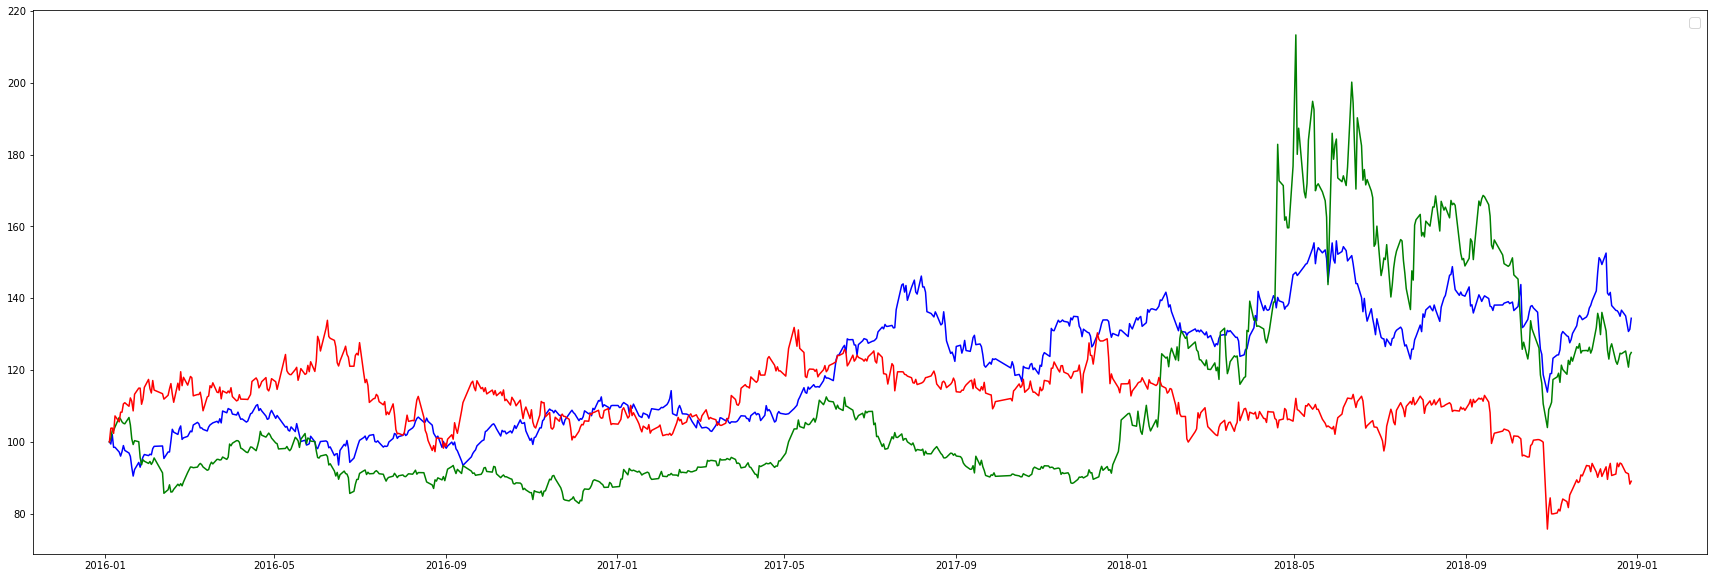

In [52]:
x = df_index1['Date']
y1 = df_index1['지수']
y2 = df_index2['지수']
y3 = df_index3['지수']
plt.figure(figsize=(30,10))
plt.legend(loc='best', ncol=2, fontsize=14)
plt.plot(x,y1,'b', x,y2,'g',x,y3,'r')
# plt.plot(x,y1,'b',label='폐기물주_지수', x,y2,'g',label='농약비료주_지수',x,y3,'r',label='제습기주_지수')


## plotly

In [53]:
# plotly
# 그래프 하나로 만들기
df_total = pd.DataFrame({'Date': df_index1['Date'], '폐기물_지수':df_index1['지수'],'농약비료_지수':df_index2['지수'],'제습기_지수':df_index3['지수']})

fig = px.line(df_total, x='Date', y=['폐기물_지수','농약비료_지수','제습기_지수'],title = '장마 테마주 지수')
fig.update_xaxes(rangeslider_visible=True)
fig.show()                

In [146]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df_index11 = df_index1.set_index('Date')
df_index22 = df_index2.set_index('Date')
df_index33 = df_index3.set_index('Date')



fig = make_subplots(
    rows=3, cols=3
    ,subplot_titles=("지수_폐기물주_2016년","지수_폐기물주_2017년","지수_폐기물주_2018년",\
                    "지수_농약비료주_2016년","지수_농약비료주_2017년","지수_농약비료주_2018년",\
                    "지수_제습기주_2016년","지수_제습기주_2017년","지수_제습기주_2018년"))

#("지수_폐기물주_2016년","지수_폐기물주_2017년","지수_제습기주_2016년",\
#지수_농약비료주_2016년","지수_농약비료주_2017년",지수_농약비료주_2017년",\
#지수_제습기주_2018년",지수_제습기주_2018년","지수_제습기주_2018년"))

fig.add_trace(go.Scatter(x= df_index11['2016-05':'2016-08'].index, y=df_index11['지수'].loc['2016-05':'2016-08']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_index22['2016-05':'2016-08'].index, y=df_index22['지수'].loc['2016-05':'2016-08']),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_index33['2016-05':'2016-08'].index, y=df_index33['지수'].loc['2016-05':'2016-08']),
              row=3, col=1)

# fig.add_vline(x ='2016-06-18')
# fig.add_vline(x ='2016-07-31')


fig.add_trace(go.Scatter(x=df_index11['2017-05':'2017-08'].index, y=df_index11['지수'].loc['2017-05':'2017-08']),
              row=2, col=2)

fig.add_trace(go.Scatter(x=df_index22['2017-05':'2017-08'].index, y=df_index22['지수'].loc['2017-05':'2017-08']),
              row=1, col=2)


fig.add_trace(go.Scatter(x=df_index33['2017-05':'2017-08'].index, y=df_index33['지수'].loc['2017-05':'2017-08']),
              row=3, col=2)

#


fig.add_trace(go.Scatter(x=df_index11['2018-05':'2018-08'].index, y=df_index11['지수'].loc['2018-05':'2018-08']),
              row=1, col=3)

fig.add_trace(go.Scatter(x=df_index22['2018-05':'2018-08'].index, y=df_index22['지수'].loc['2018-05':'2018-08']),
              row=2, col=3)

fig.add_trace(go.Scatter(x=df_index33['2018-05':'2018-08'].index, y=df_index33['지수'].loc['2018-05':'2018-08']),
              row=3, col=3)






# fig.add_vline(x ='2016-06-18')
# fig.add_vline(x ='2016-07-31')

fig.add_vline(x ='2017-06-24')
fig.add_vline(x ='2017-07-29')

# fig.add_vline(x ='2018-06-26')
# fig.add_vline(x ='2018-07-11')


fig.update_layout(height=1200, width=2000,
                  title_text="장마 테마주 추세")

# fig.show()

In [142]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df_index11 = df_index1.set_index('Date')
df_index22 = df_index2.set_index('Date')
df_index33 = df_index3.set_index('Date')



fig = make_subplots(
    rows=3, cols=3)
#     ,subplot_titles=("지수_폐기물주_2016년","지수_폐기물주_2017년","지수_폐기물주_2018년",\
#                     "지수_농약비료주_2016년","지수_농약비료주_2017년","지수_농약비료주_2018년",\
#                     "지수_제습기주_2016년","지수_제습기주_2017년","지수_제습기주_2018년"))

#("지수_폐기물주_2016년","지수_폐기물주_2017년","지수_제습기주_2016년",\
#지수_농약비료주_2016년","지수_농약비료주_2017년",지수_농약비료주_2017년",\
#지수_제습기주_2018년",지수_제습기주_2018년","지수_제습기주_2018년"))

fig.add_trace(go.Scatter(x= df_index11['2016-05':'2016-08'].index, y=df_index11['지수'].loc['2016-05':'2016-08']),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df_index22['2016-05':'2016-08'].index, y=df_index22['지수'].loc['2016-05':'2016-08']),
              row=1, col=2)

fig.add_trace(go.Scatter(x=df_index33['2016-05':'2016-08'].index, y=df_index33['지수'].loc['2016-05':'2016-08']),
              row=1, col=3)

# fig.add_vline(x ='2016-06-18')
# fig.add_vline(x ='2016-07-31')


fig.add_trace(go.Scatter(x=df_index11['2017-05':'2017-08'].index, y=df_index11['지수'].loc['2017-05':'2017-08']),
              row=2, col=1)

fig.add_trace(go.Scatter(x=df_index22['2017-05':'2017-08'].index, y=df_index22['지수'].loc['2017-05':'2017-08']),
              row=2, col=2)


fig.add_trace(go.Scatter(x=df_index33['2017-05':'2017-08'].index, y=df_index33['지수'].loc['2017-05':'2017-08']),
              row=2, col=3)

#


fig.add_trace(go.Scatter(x=df_index11['2018-05':'2018-08'].index, y=df_index11['지수'].loc['2018-05':'2018-08']),
              row=3, col=1)

fig.add_trace(go.Scatter(x=df_index22['2018-05':'2018-08'].index, y=df_index22['지수'].loc['2018-05':'2018-08']),
              row=3, col=2)

fig.add_trace(go.Scatter(x=df_index33['2018-05':'2018-08'].index, y=df_index33['지수'].loc['2018-05':'2018-08']),
              row=3, col=3)






# fig.add_vline(x ='2016-06-18')
# fig.add_vline(x ='2016-07-31')

# fig.add_vline(x ='2017-06-24')
# fig.add_vline(x ='2017-07-29')

# fig.add_vline(x ='2018-06-26')
# fig.add_vline(x ='2018-07-11')


fig.update_layout(height=1200, width=2000,
                  title_text="장마 테마주 추세")

# fig.show()

100   2015-06-01
101   2015-06-02
102   2015-06-03
103   2015-06-04
104   2015-06-05
         ...    
160   2015-08-25
161   2015-08-26
162   2015-08-27
163   2015-08-28
164   2015-08-31
Name: Date, Length: 65, dtype: datetime64[ns]

348   2016-06-01
349   2016-06-02
350   2016-06-03
351   2016-06-07
352   2016-06-08
         ...    
406   2016-08-24
407   2016-08-25
408   2016-08-26
409   2016-08-29
410   2016-08-30
Name: Date, Length: 63, dtype: datetime64[ns]

In [26]:
df_index3['Date'][595:659] # 495: 끝 2017년

595   2017-06-01
596   2017-06-02
597   2017-06-05
598   2017-06-07
599   2017-06-08
         ...    
654   2017-08-25
655   2017-08-28
656   2017-08-29
657   2017-08-30
658   2017-08-31
Name: Date, Length: 64, dtype: datetime64[ns]

## 개별 주식의 추세

In [12]:

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (1) 폐기물: 2011년 7월 27일 부근 변동성 큰 주식
'KG ETS',
'인선이엔티',
'와이엔텍',
'코엔텍',
'스페코'

]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2016-01-01', '2018-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  KG ETS 회사코드:  151860
회사이름:  스페코 회사코드:  013810
회사이름:  와이엔텍 회사코드:  067900
회사이름:  인선이엔티 회사코드:  060150
회사이름:  코엔텍 회사코드:  029960


In [13]:
#주가 딕셔너리에 넣기-> 유가,개별 주식간 비교에 사용

stocklst = fdr.StockListing('KRX')
company_lst = [
# 장마 테마주
# (2) 농약비료
'경농' ,
# '조비' ,
'동방아그로',
# '남해화학'
]
codes_lst = stocklst[stocklst.Name.apply(lambda stock: stock in company_lst)].Symbol.to_list() 


price_history = dict()

for code in codes_lst:
    df = fdr.DataReader(code,'2011-01-01', '2011-12-31')
    price_history[code]= df['Close']   # 회사코드: [과거주가 리스트] 
    company_name = stocklst[stocklst['Symbol']== str(code)]['Name'].values[0]
    print('회사이름: ',company_name , '회사코드: ',str(code) )
        
df_p = pd.DataFrame(price_history)
df_p.reset_index(inplace=True)

# 코드 문자열로 바꿔주기
code_str = list(map(str,codes_lst))

fig = px.line(df_p, x='Date', y= code_str)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

회사이름:  경농 회사코드:  002100
회사이름:  동방아그로 회사코드:  007590


In [14]:
'KG ETS',
'인선이엔티',

=장마
- 폐기물 관련주
'KG ETS'
'인선이엔티'
'와이엔텍' 
# '제넨바이오' *
# '코엔텍'
# '그린플러스' *
'스페코'
'태영건설'

 - 농약/비료
'경농' *
'조비' 
'동방아그로' *
'남해화학'
백광소재
효성오앤비

- 제습기
위닉스
신일전자
파세코
코웨이


남해화학 동방아그로 조비 
파루 경농



= 가뭄
뉴보텍 - 상하수관 및 하수정비

동양철관 - 수도관 및 배관용 장비 제조 및 판매

뉴로스 - 상하수도 및 수처리

자연과환경 - 4대강 관련주

CSA코믹스 - 수처리

웰크론한텍 - 폐수처리 및 담수처리 전문업체


열대야 테마주 
'신일전자'
'파세코'
'에스씨디'
'빙그레'
'위닉스'
'태경케미컬'
'위니아딤채'
'에스피지'
'롯데하이마트'
'비엠티'

SyntaxError: invalid syntax (Temp/ipykernel_15532/1647323608.py, line 4)

## 코스피, 코스닥 지수

In [ ]:
# df_index = fdr.DataReader('KS100','2019-01-01','2019-12-31') 왜 안될까

## 다음날 아침 급등주 캐치 전략

In [ ]:
df.head()

In [ ]:
# 전날 종가 다음날 고가 변동률

diff_history = dict()

for code in codes_fire:
    df = fdr.DataReader(code,'2019-01-02', '2019-12-31')
    diff_history[code]= df['Change']   # 회사코드: [과거주가 리스트] 

df_diff = pd.DataFrame(diff_history)
df_diff

In [ ]:
# 구제역 관련주
# 대체식품(수산업,닭)
: 한성기업,정다운,동우팜투테이블,사조오양, 
신라교역, 마니커, 동원산업 
신라에스지 
하림 
동원수산 
이지홀딩스
팜스토리


# 사료
한일사료

# 백신
우성사료 우진비앤지 대성미생물 

# 석회
태경비케이 



In [ ]:
# ai 관련주(주로 백신) : ai가 길어지면 대체식품주 오를 수 있음

파루
제일바이오
이글벳
진원생명과학
팜스웰바이오
씨티씨바이오
대한뉴팜

